# MDPs in TensorFlow - Navigation with Noisy Directions

In this IPython notebook, we'll explore **Continuous State-Action MDPs** with stochastic transitions in TensorFlow. All stochastic transitions will be defined by a deterministic function combined with external noise that is considered an input to the MDP cell.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import abc
import functools
import time

import utils

%matplotlib inline

## Modeling MDPs in TensorFlow

All classes defining MDPs must inherit from abstract class ```MDP```.

In [2]:
class MDP(metaclass=abc.ABCMeta):
    
    @abc.abstractproperty
    def action_size(self):
        return
    
    @abc.abstractproperty
    def state_size(self):
        return

    @abc.abstractmethod
    def transition(self, state, action):
        return

    @abc.abstractmethod
    def reward(self, state, action):
        return


### Navigation in 2D grid with deceleration zone at the center

In [3]:
class Navigation(MDP):

    def __init__(self, graph, grid, deceleration, max_theta=20):
        self.graph = graph

        self.ndim = grid["ndim"]
        self.max_theta = max_theta

        with self.graph.as_default():

            # grid constants
            self.__size = tf.constant(grid["size"], dtype=tf.float32)
            self.__goal = tf.constant(grid["goal"], dtype=tf.float32)

            # deceleration constants
            self.__center = tf.constant(deceleration["center"], dtype=tf.float32)
            self.__decay  = tf.constant(deceleration["decay"],  dtype=tf.float32)

            # numerical constants
            self.__0_00 = tf.constant(0.00, dtype=tf.float32)
            self.__1_00 = tf.constant(1.00, dtype=tf.float32)
            self.__2_00 = tf.constant(2.00, dtype=tf.float32)
            self.__8_00 = tf.constant(8.00, dtype=tf.float32)

    @property
    def action_size(self):
        return self.ndim
    
    @property
    def state_size(self):
        return self.ndim
        
    def transition(self, state, action, noise):

        with self.graph.as_default():

            # apply rotation noise
            cos = tf.cos(self.max_theta * np.pi / 180 * noise)
            sin = tf.sin(self.max_theta * np.pi / 180 * noise)

            noise_matrix = tf.stack([cos, -sin, sin, cos], axis=1)
            noise_matrix = tf.reshape(noise_matrix, [-1, 2, 2])
            noisy_action = tf.matmul(noise_matrix, tf.reshape(action, [-1, 2, 1]))
            noisy_action = tf.reshape(noisy_action, [-1, 2])

            # distance to center of deceleration zone
            d = tf.sqrt(tf.reduce_sum(tf.square(state - self.__center), 1, keep_dims=True))

            # deceleration_factor
            deceleration = self.__2_00 / (self.__1_00 + tf.exp(-self.__decay * d)) - self.__1_00

            # next position
            next_state = state + deceleration * noisy_action
            
            # avoid getting out of map
            next_state = tf.clip_by_value(next_state, self.__0_00, self.__size)

        return next_state

    def reward(self, state, action):
        
        with self.graph.as_default():
            # norm L-1 (manhattan distance)
            # r = -tf.reduce_sum(tf.abs(state - self.__goal), 1, keep_dims=True)

            # norm L-2 (euclidean distance)
            r = -tf.sqrt(tf.reduce_sum(tf.square(state - self.__goal), 1, keep_dims=True))

        return r

## Encoding an MDP as a Recurrent Neural Net

### Encapsulate MDP components into RNN cell

In [4]:
class MDP_RNNCell(tf.nn.rnn_cell.RNNCell):

    def __init__(self, mdp, policy):
        self.mdp = mdp
        self.policy = policy

    @property
    def action_size(self):
        return self.mdp.action_size
        
    @property
    def state_size(self):
        return self.mdp.state_size + 1

    @property
    def output_size(self):
        return self.state_size + self.mdp.action_size + 1

    def __call__(self, inputs, state, scope=None):

        with self.mdp.graph.as_default():

            # add policy network
            mdp_action = self.policy(state)

            # separate MDP state and timestep
            h = tf.unstack(state, axis=1)
            sz = self.mdp.state_size
            mdp_state = tf.stack(h[:sz], axis=1)
            timestep  = tf.reshape(h[sz], [-1, 1])

            # add MDP components to the RNN cell output
            noise = inputs
            mdp_next_state = self.mdp.transition(mdp_state, mdp_action, noise)
            mdp_reward = self.mdp.reward(mdp_next_state, mdp_action)

            # gather MDP state and timestep
            mdp_next_state = tf.concat([mdp_next_state, timestep + 1], axis=1)
            
            # concatenate outputs
            outputs = tf.concat([mdp_reward, mdp_next_state, mdp_action], axis=1)

        return outputs, mdp_next_state


### Define the MDP's policy as a Multi-Layer Perceptron (MLP)

In [5]:
class PolicyNetwork(object):
    
    def __init__(self, graph, layers, limits=1.0):
        self.graph = graph
        self.policy = functools.partial(self.__build_network, layers, limits)
    
    def __call__(self, state):
        return self.policy(state)
    
    def __build_network(self, layers, limits, state):

        with self.graph.as_default():

            with tf.variable_scope('policy'):

                # hidden layers
                outputs = state
                for i, n_h in enumerate(layers[1:]):
                    if i != len(layers)-2:
                        activation = tf.nn.relu
                    else:
                        activation = tf.nn.tanh

                    outputs = tf.layers.dense(outputs,
                                              units=n_h,
                                              activation=activation,
                                              kernel_initializer=tf.glorot_normal_initializer(),
                                              name="layer"+str(i+1))

                # add action limits over last tanh layer
                action = tf.constant(limits) * outputs

        return action

## Unroll the model given a finite horizon

In [6]:
class MDP_RNN(object):
    
    def __init__(self, mdp, policy, batch_size=1):
        self.cell = MDP_RNNCell(mdp, policy)
        self.batch_size = batch_size
        self.graph = mdp.graph
    
    def unroll(self, inputs, initial_state):

        state_size = self.cell.state_size

        with self.graph.as_default():

            # dynamic time unrolling
            outputs, final_state = tf.nn.dynamic_rnn(
                self.cell,
                inputs,
                initial_state=initial_state,
                dtype=tf.float32)

            # gather reward, state and action series
            outputs = tf.unstack(outputs, axis=2)
            max_time = int(inputs.shape[1])
            reward_series = tf.reshape(outputs[0], [-1, max_time, 1])
            state_series  = tf.stack(outputs[1:1+state_size], axis=2)
            action_series = tf.stack(outputs[1+state_size:],  axis=2)
        
        return reward_series, state_series, action_series, final_state


## Define the Policy Optimizer

In [7]:
class PolicyOptimizer(object):
    
    def __init__(self, graph, loss, total, learning_rate, initial_state, noise_generator):
        self.graph = graph

        self.loss = loss
        self.total = total
        
        self.initial_state = initial_state
        
        self.noise = noise_generator
        
        # optimization hyperparameters
        self.learning_rate = learning_rate

        with self.graph.as_default():
            # backprop via RMSProp
            self.train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

            # global initializer
            self.init_op = tf.global_variables_initializer()

    def run(self, sess, epoch=100, show_progress=True):
        # initialize variables
        sess.run(self.init_op)
        
        losses = []
        for epoch_idx in range(epoch):
            # generate inputs (noise)
            inputs_data = self.noise()

            # backprop and update weights
            _, loss, total = sess.run([self.train_step, self.loss, self.total],
                                      feed_dict={inputs: inputs_data, initial_state: self.initial_state})

            # store and show loss information
            losses.append(loss)
            if show_progress:
                print('Epoch {0:5}: loss = {1}\r'.format(epoch_idx, loss), end='')
        print()

        return losses, total

## Define the noise generator

In [8]:
class NoiseGenerator(object):
    
    def __init__(self, batch_size, max_time, ratio):
        self.size = (batch_size, max_time, 1)
        self.noise_size = (int(ratio * batch_size), max_time, 1)

        # no noise at all...
        shape = (batch_size - self.noise_size[0], max_time, 1)
        self.zero_noise = np.zeros(shape=shape).astype(np.float32)

    def __call__(self):
        # sample noise data from normal distribution
        random_noise = np.random.normal(size=self.noise_size).astype(np.float32)
        return np.concatenate([random_noise, self.zero_noise], axis=0)

## Putting all components together

Let's first of all create the computational graph to which all necessary operations will be added.

In [9]:
graph = tf.Graph()

### Instantiate the MDP model

In [10]:
# navigation parameters
grid = {
    'ndim': 2,
    'size': (10.0, 10.0),
    'start': (1.0,  5.0),
    'goal': (8.0,  5.0)
}

deceleration = {
    'center': (5.0, 5.0),
    'decay': 2.0
}

# MDP model
mdp = Navigation(graph, grid, deceleration)

### Instantiate the Policy Network

In [11]:
# define policy network
layers = [mdp.state_size + 1, 10, 5, mdp.action_size]
policy = PolicyNetwork(graph, layers)

### Unroll the RNN model

In [12]:
batch_size = 1000
max_time = 9

with graph.as_default():

    # initial state
    initial_state = tf.placeholder(tf.float32, shape=(None, mdp.state_size + 1), name="initial_state")

    # inputs (noise)
    inputs = tf.placeholder(tf.float32, shape=(None, max_time, 1), name="inputs")

# unroll MDP model
rnn = MDP_RNN(mdp, policy, batch_size)
rewards, states, actions, final_state = rnn.unroll(inputs, initial_state)

### Define the loss function

In [13]:
with graph.as_default():
    # loss based on total reward
    total = tf.reduce_sum(rewards, 1)
    loss  = tf.reduce_mean(tf.square(total))

### Train the Policy Network

In [14]:
def train(graph, optimizer, epoch):

    # saver
    with graph.as_default():
        saver = tf.train.Saver()

    with tf.Session(graph=graph) as sess:

        start = time.time()

        # optimize it, babe!
        losses, total_cost_per_batch = optimizer.run(sess, epoch)

        end = time.time()
        uptime = end - start
        print("Done in {0:.6f} sec.\n".format(uptime))

        # save model
        save_path = saver.save(sess, 'models/model.ckpt')
        print("Model saved in file: %s" % save_path)

    return losses, total_cost_per_batch, saver, uptime

### Define the initial state for all batches

In [15]:
def build_initial_state(x0, y0, batch_size):
    x_init = np.full([batch_size], x0, np.float32)
    y_init = np.full([batch_size], y0, np.float32)
    t_init = np.zeros([batch_size], np.float32)
    return np.stack([x_init, y_init, t_init], axis=1)

It's time to train our model!

In [16]:
# hyperparameters
epoch = 200
learning_rate = 0.001

# inputs
noise_ratio = 1.00
noise_generator = NoiseGenerator(batch_size, max_time, noise_ratio)

# initial state
x0, y0 = grid['start']
s0 = build_initial_state(x0, y0, batch_size)

# optimizer
optimizer = PolicyOptimizer(graph, loss, total, learning_rate, s0, noise_generator)

# results
losses, total_cost, saver, uptime = train(graph, optimizer, epoch)

Epoch   199: loss = 766.40631103515622
Done in 10.344069 sec.

Model saved in file: models/model.ckpt


### Plot loss function and cost per batch

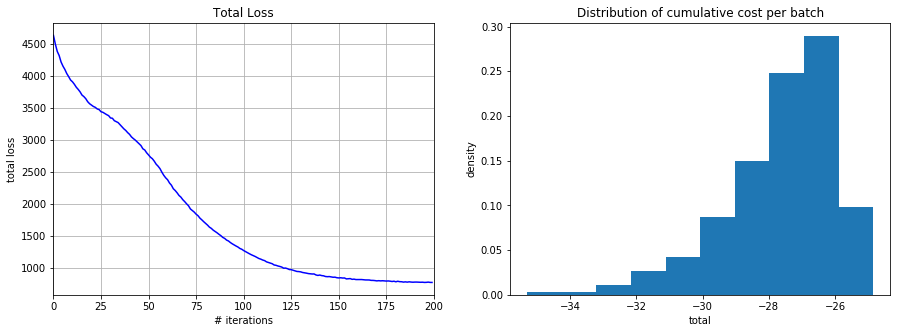

In [17]:
fig = plt.figure(figsize=(15, 5))

# plotting losses
ax = fig.add_subplot(121)
utils.plot_loss_function(ax, losses, epoch)

# histogram of cumulative cost per batch
ax = fig.add_subplot(122)
utils.plot_total_cost_per_batch(ax, total_cost)

## Evaluate Policy

Let's evaluate the learned policy in an action grid for different timesteps.

In [18]:
def build_initial_states_grid(x_grid_size, y_grid_size, timestep):
    batch_size = x_grid_size * y_grid_size
    x_grid = np.linspace(0.0, grid['size'][0], x_grid_size)
    y_grid = np.linspace(0.0, grid['size'][1], y_grid_size)
    initial_states_grid = []
    for x in x_grid:
        for y in y_grid:
            initial_states_grid.append([x, y, timestep])
    return initial_states_grid, batch_size

In [19]:
def evaluate_policy(grid_size, state_size, timesteps):
    initial_states_grids = []
    actions = []
    
    graph = tf.Graph()
    with graph.as_default():
        
        # re-initialize initial_state placeholder
        batch_size = grid_size * grid_size
        initial_state = tf.placeholder(shape=(batch_size, state_size), dtype=np.float32, name='initial_state')

        # re-initialize policy
        with tf.variable_scope('rnn'):
            policy = PolicyNetwork(graph, layers)
            action = policy(initial_state)

        saver = tf.train.Saver()
        with tf.Session(graph=graph) as sess:
            saver.restore(sess, 'models/model.ckpt')
            
            for timestep in timesteps:

                # instantiate initial states in a grid 
                s0, batch_size = build_initial_states_grid(grid_size, grid_size, timestep)
                initial_states_grids.append(s0)

                # evaluate policy for given initial states
                a = sess.run(action, feed_dict={initial_state: s0})
                actions.append(a)
    
    return initial_states_grids, actions

INFO:tensorflow:Restoring parameters from models/model.ckpt


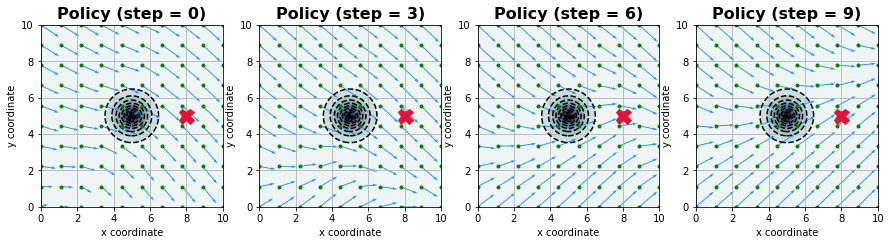

In [20]:
grid_size = 10
timesteps = np.array([0.0, max_time / 3, 2 / 3 * max_time, max_time], dtype=np.int32)
initial_states_grid, policy_actions = evaluate_policy(grid_size, mdp.state_size + 1, timesteps)

fig = plt.figure(figsize=(15, 5))
for i, timestep in enumerate(timesteps):
    ax = fig.add_subplot(1, len(timesteps), i+1)
    utils.plot_policy(ax, grid, deceleration, initial_states_grid[i], policy_actions[i], timestep)

## Simulate policy

In [21]:
def simulate(graph, series, s0, batch_size=1, max_time=10):
    with graph.as_default():
        saver = tf.train.Saver()

    with tf.Session(graph=graph) as sess:
        # restore learned policy model
        saver.restore(sess, 'models/model.ckpt')

        # sample noise data
        noise = np.random.normal(size=(batch_size, max_time, 1)).astype(np.float32)

        # simulate MDP trajectories
        result = sess.run(series, feed_dict={inputs: noise, initial_state: s0})

    return result

In [22]:
max_time = 9
batch_size = 3

# initial states for simulation
x0, y0 = grid['start']
delta_y = [0.0, -3.0, -1.5, 1.5, 3.0]
initial_states = []
for delta in delta_y:
    s0 = build_initial_state(x0, y0 + delta, batch_size)
    initial_states.append(s0)
initial_states = np.concatenate(initial_states, axis=0)

# total batch_size
batch_size = initial_states.shape[0]

# simulate!
rewards, states, actions = simulate(graph, [rewards, states, actions], initial_states, batch_size, max_time)

INFO:tensorflow:Restoring parameters from models/model.ckpt


### Plot simulated trajectories

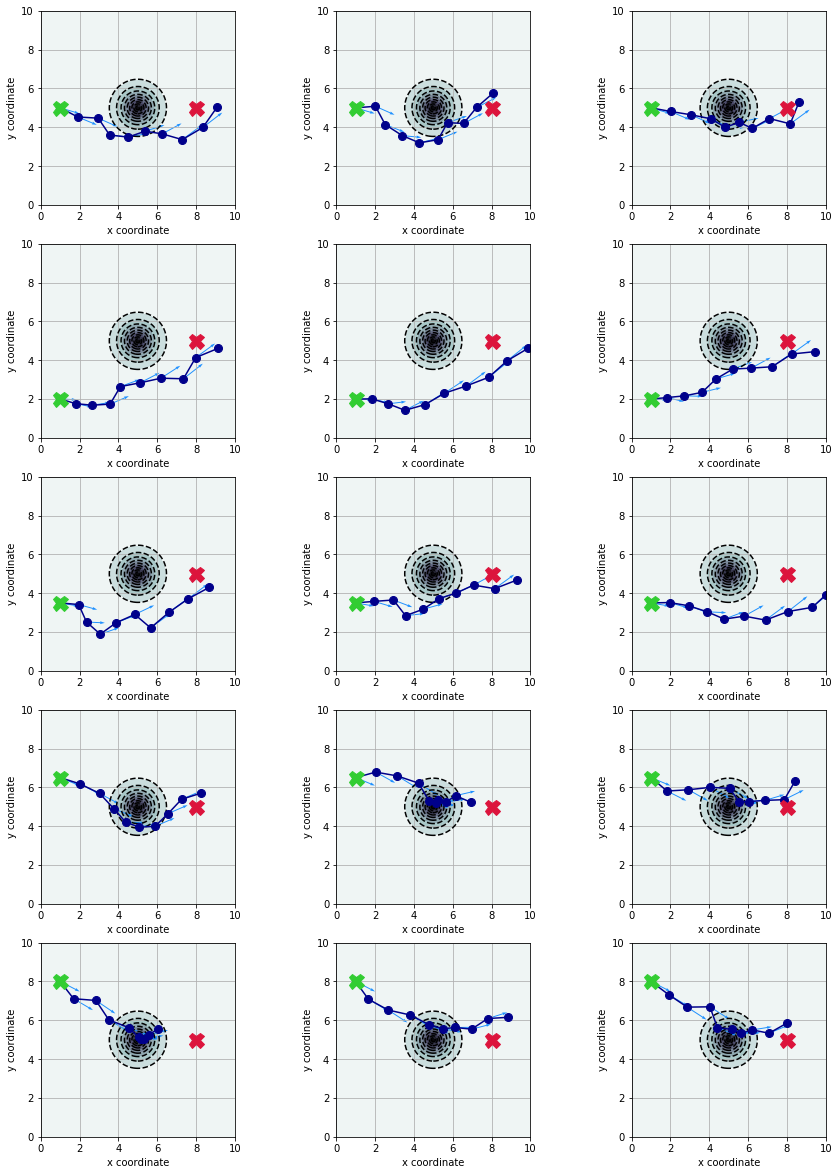

In [23]:
fig = plt.figure(figsize=(15, 25))
utils.plot_simulations(fig, grid, deceleration, initial_states, delta_y, states, actions)